In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from train import run_flsc, FlscConfig, create_config, get_data_for_config, run_fedprox

In [6]:
from train import FedProxConfig

conf = create_config(
     algorithm="ifca",
     dataset="cifar10",
     rounds=10,
     epochs=8,
     n_clients=80,
     clients_per_round=1.0,
     clusters=4,
     clusters_per_client=3,
     imbalance_type="feature_distribution",
     imbalance_value=10,
     penalty=0,
 )

In [7]:
train, test = get_data_for_config(conf.dataset, conf.n_clients, conf.imbalance_type, conf.imbalance_value, seed=42, conn=None)

Files already downloaded and verified


In [8]:
def dataset_lens(ds):
    return np.array(list(map(lambda dl: len(dl.dataset), ds)))

In [9]:
train_lens = dataset_lens(train)
test_lens = dataset_lens(test)

In [10]:
from datasets.imbalancing.stats import li_ldi_qi
datasets = list(map(lambda dl: dl.dataset, train))
li, ldi, qi = li_ldi_qi(datasets)

In [11]:
imbalances = pd.DataFrame({
    "client": range(len(li)),
    "imbalance_type": "label_distribution",
    "imbalance_value": 0.1,
    "label_imbalance": li,
    "label_distribution_imbalance": ldi,
    "quantity_imbalance": qi,
})
imbalances

,client,imbalance_type,imbalance_value,label_imbalance,label_distribution_imbalance,quantity_imbalance
0,0,label_distribution,0.1,1.600000,0.012083,1.139089
1,1,label_distribution,0.1,1.514286,0.005120,0.933253
2,2,label_distribution,0.1,1.538462,0.009471,0.903277
3,3,label_distribution,0.1,1.432432,0.007023,0.903277
4,4,label_distribution,0.1,1.460317,0.005224,1.558753
...,...,...,...,...,...,...
75,75,label_distribution,0.1,1.869565,0.018919,0.599520
76,76,label_distribution,0.1,1.571429,0.010420,0.695444
77,77,label_distribution,0.1,1.558824,0.009417,0.809353
78,78,label_distribution,0.1,1.416667,0.006018,0.565548


<Axes: ylabel='Count'>

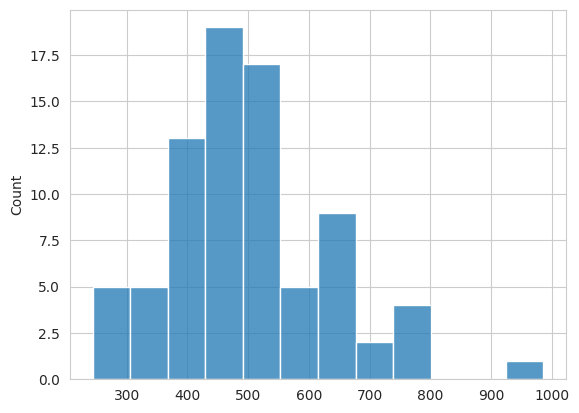

In [12]:
sns.histplot(train_lens)

<Axes: ylabel='Count'>

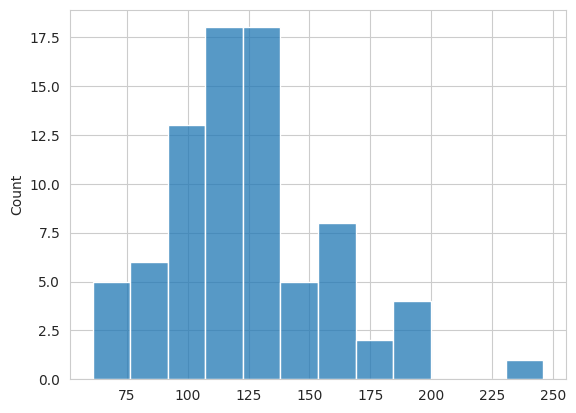

In [13]:
sns.histplot(test_lens)

In [14]:
results = run_flsc(conf, train, test) if conf.algorithm.lower() in ["ifca", "flsc"] else run_fedprox(conf, train, test)

Round:   0%|          | 0/10 [00:00<?, ?it/s]

/home/lukas/Work/masterthesis-clustered-fl/federated_learning/flsc.py:186: UserWarning: No clients for cluster 1
  warnings.warn(f"No clients for cluster {c}")
/home/lukas/Work/masterthesis-clustered-fl/federated_learning/flsc.py:186: UserWarning: No clients for cluster 0
  warnings.warn(f"No clients for cluster {c}")
/home/lukas/Work/masterthesis-clustered-fl/federated_learning/flsc.py:186: UserWarning: No clients for cluster 1
  warnings.warn(f"No clients for cluster {c}")
/home/lukas/Work/masterthesis-clustered-fl/federated_learning/flsc.py:186: UserWarning: No clients for cluster 0
  warnings.warn(f"No clients for cluster {c}")
/home/lukas/Work/masterthesis-clustered-fl/federated_learning/flsc.py:186: UserWarning: No clients for cluster 1
  warnings.warn(f"No clients for cluster {c}")
/home/lukas/Work/masterthesis-clustered-fl/federated_learning/flsc.py:186: UserWarning: No clients for cluster 0
  warnings.warn(f"No clients for cluster {c}")
/home/lukas/Work/masterthesis-clustered-

In [15]:
metrics, infos = results.as_dataframes()
metrics

,round,client,stage,variable,value
0,0,0,train,loss,2.159223
1,0,0,train,n_samples,570.000000
2,0,0,test,loss,1.933756
3,0,0,test,f1,0.272003
4,0,0,test,n_samples,142.000000
...,...,...,...,...,...
3995,9,79,train,loss,1.606622
3996,9,79,train,n_samples,500.000000
3997,9,79,test,loss,1.999326
3998,9,79,test,f1,0.250685


In [16]:
df = metrics.query("stage == 'train' and variable == 'loss'")
# df = results.query("stage == 'test' and variable == 'f1'")

<Axes: xlabel='round', ylabel='value'>

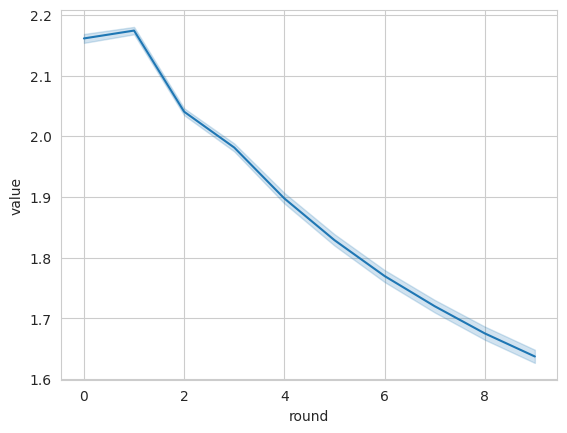

In [17]:
sns.lineplot(df, x="round", y="value")

In [18]:
import json
infos = pd.concat((infos.drop(columns="info"), pd.json_normalize(infos['info'].apply(json.loads))), axis=1)

In [19]:
df = infos.query("stage == 'train'")\
    .drop(columns=["stage", "client"])\
    .groupby(["round", "cluster_identities"])\
    .size()\
    .reset_index()\
    .rename(columns={0: "count"})

In [20]:
df 

,round,cluster_identities,count
0,0,0,20
1,0,1,17
2,0,2,20
3,0,3,23
4,1,0,2
5,1,2,77
6,1,3,1
7,2,2,24
8,2,3,56
9,3,2,24
